In [142]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
data = load_digits()
X, y = data.data, data.target
digit1, digit2 = 1, 8
y[y == digit1]
X[y == digit1], y[y == digit1].shape, X[y == digit2].shape, y[y == digit2].shape
X = np.concatenate((X[y == digit1], X[y == digit2]), axis=0)
y_1, y_2 = np.full(y[y == digit1].shape, -1), np.full(y[y == digit2].shape, 1)
y = np.concatenate((y_1, y_2), axis=0)
X.shape, y.shape, X, y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)
X_test.shape, X_test

((250, 64),
 array([[ 0.,  0., 11., ..., 16., 16., 12.],
        [ 0.,  0.,  3., ..., 10.,  0.,  0.],
        [ 0.,  0.,  6., ...,  3.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., 13.,  2.,  0.],
        [ 0.,  0.,  3., ..., 16.,  7.,  0.],
        [ 0.,  0.,  1., ..., 12.,  2.,  0.]]))

###  先定义一个决策树桩，本质上就是一个带有阈值划分的决策树结点。

In [143]:
class DecisionStump():
    def __init__(self):
        # 基于划分阈值决定样本分类为1还是-1
        self.polarity = 1
        # 特征索引
        self.feature_index = None
        # 特征划分阈值
        self.threshold = None
        # 指示分类准确率的值
        self.alpha = None

### 直接定义一个Adaboost算法类，将上述算法流程在类中实现

In [144]:
class Adaboost():
    # 弱分类器个数
    def __init__(self, n_estimators=5):
        self.n_estimators = n_estimators
    # Adaboost拟合算法

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # (1) 初始化权重分布为均匀分布 1/N
        w = np.full(n_samples, (1/n_samples))

        self.estimators = []
        # (2) for m in (1,2,...,M)
        for _ in range(self.n_estimators):
            # (2.a) 训练一个弱分类器：决策树桩
            clf = DecisionStump()
            # 设定一个最小化误差
            min_error = float('inf')
            # 遍历数据集特征，根据最小分类误差率选择最优划分特征
            for feature_i in range(n_features):
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)
                # 尝试将每一个特征值作为分类阈值
                for threshold in unique_values:
                    p = 1
                    # 初始化所有预测值为1
                    prediction = np.ones(np.shape(y))
                    # 小于分类阈值的预测值为-1
                    prediction[X[:, feature_i] < threshold] = -1
                    # 2.b 计算误差率
                    error = sum(w[y != prediction])

                    # 如果分类误差大于0.5，则进行正负预测翻转
                    # E.g error = 0.8 => (1 - error) = 0.2
                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # 一旦获得最小误差则保存相关参数配置
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_index = feature_i
                        min_error = error

            # 2.c 计算基分类器的权重
            clf.alpha = 0.5 * np.log((1.0 - min_error) / (min_error + 1e-10))
            # 初始化所有预测值为1
            predictions = np.ones(np.shape(y))
            # 获取所有小于阈值的负类索引
            negative_idx = (
                clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold)
            # 将负类设为 '-1'
            predictions[negative_idx] = -1
            # 2.d 更新样本权重
            w *= np.exp(-clf.alpha * y * predictions)
            w /= np.sum(w)

            # 保存该弱分类器
            self.estimators.append(clf)

    # 定义预测函数
    def predict(self, X):
        n_samples = np.shape(X)[0]
        y_pred = np.zeros((n_samples, 1))
        # 计算每个弱分类器的预测值
        for clf in self.estimators:
            # 初始化所有预测值为1
            predictions = np.ones(np.shape(y_pred))
            # 获取所有小于阈值的负类索引
            negative_idx = (
                clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold)
            # 将负类设为 '-1'
            predictions[negative_idx] = -1
            # 2.e 对每个弱分类器的预测结果进行加权
            y_pred += clf.alpha * predictions

        # 返回最终预测结果
        y_pred = np.sign(y_pred).flatten()
        return y_pred

###  算法效果

In [152]:
adaboost = Adaboost(n_estimators=5)
adaboost.fit(X_train, y_train)
pred=adaboost.predict(X_test)
(pred == y_test).mean()
for e in adaboost.estimators:
    print(e.alpha,e.threshold)

0.9014046523539863 13.0
0.9823893160641388 11.0
0.7833266040489625 16.0
0.912907141929706 9.0
0.6337470580725589 6.0


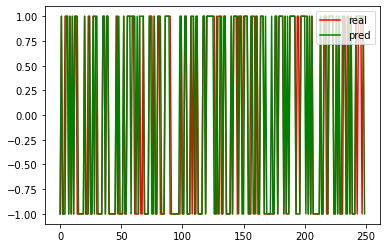

In [146]:
import matplotlib.pyplot as plt
plt.plot(range(len(X_test)),y_test,c='r',label='real')
plt.plot(pred,c='g',label='pred')
plt.legend(loc="upper right")
plt.show()

In [147]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=8)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_score(pred, y_test)

0.928

In [153]:
import matplotlib.pyplot as plt
plt.plot(range(len(X_test)),y_test,c='r',label='real')
plt.plot(pred,c='g',label='pred')
plt.legend(loc="upper right")
plt.show()

SyntaxError: invalid character in identifier (<ipython-input-153-811db9cf43a1>, line 4)